## Skin cancer detection and classification

In [1]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(r'C:\Users\soham\OneDrive\Desktop\New folder (2)\Dataset\Train')
data_dir_test = pathlib.Path(r'C:\Users\soham\OneDrive\Desktop\New folder (2)\Dataset\Test')

In [3]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Data Visualization**

Found 6739 files belonging to 9 classes.


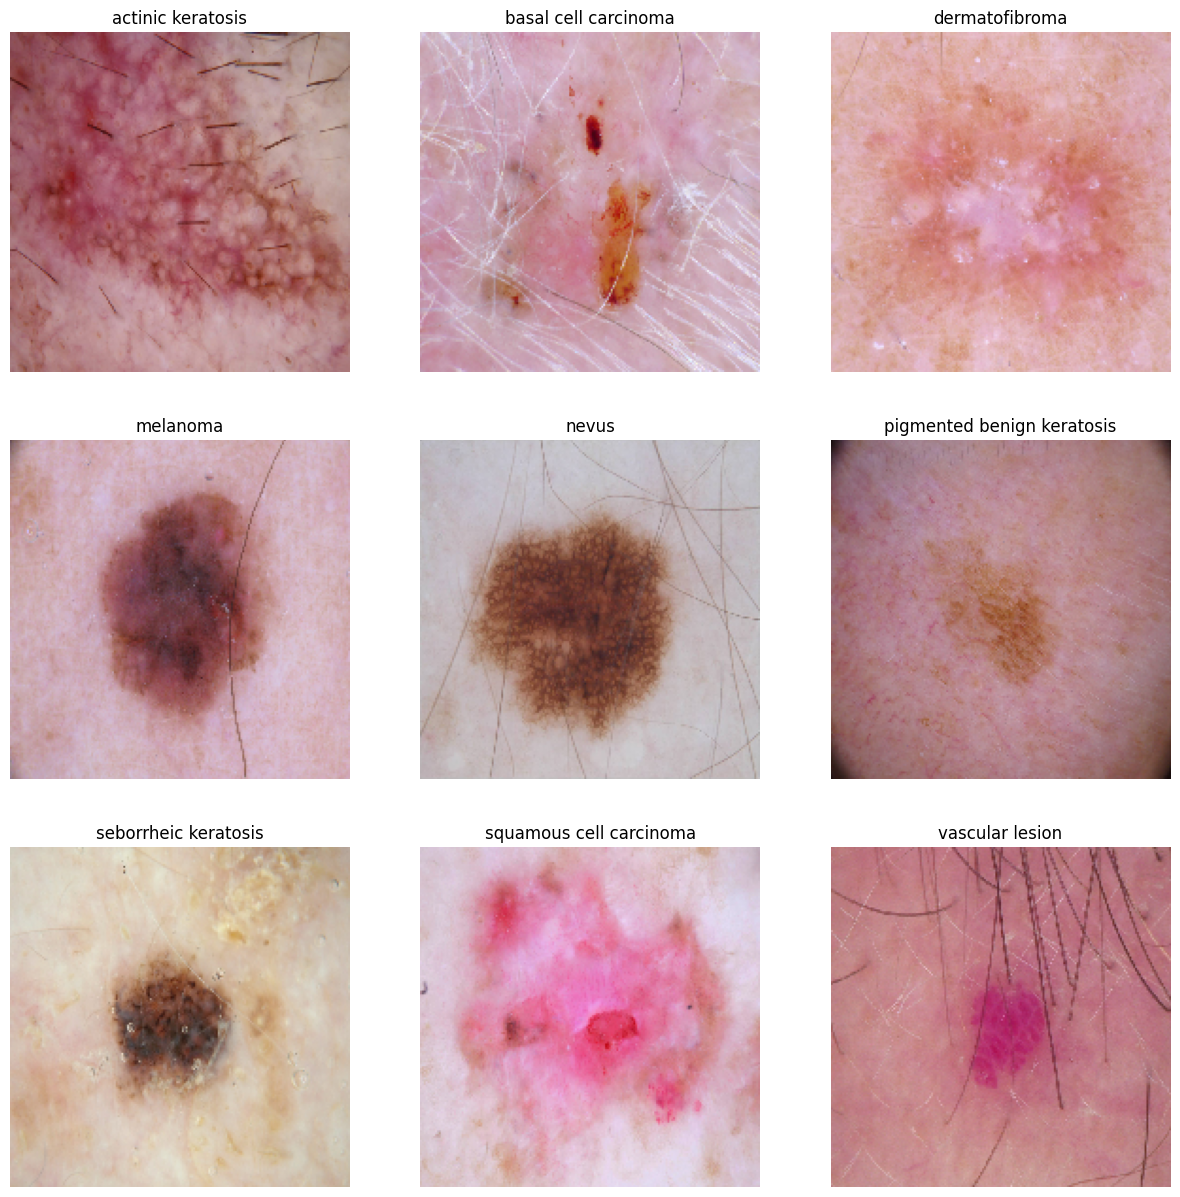

In [4]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset.**

In [5]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

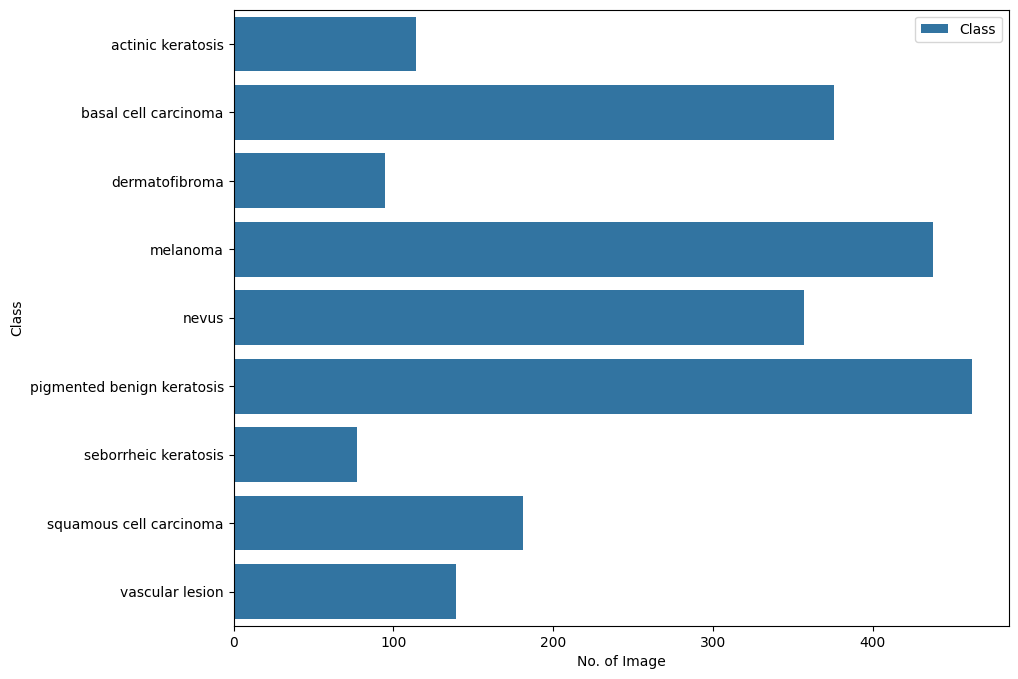

In [6]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [7]:
#install Augmentor
!pip install Augmentor

In [8]:
import os
import Augmentor

path_to_training_dataset = r'C:\Users\soham\OneDrive\Desktop\New folder (2)\Dataset\Train'

for i in class_names:
    class_path = os.path.join(path_to_training_dataset, i)
    
    # Check if the path exists
    if os.path.exists(class_path):
        p = Augmentor.Pipeline(class_path)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(500)  # Adding 500 samples per class
    else:
        print(f"Directory {class_path} does not exist.")


Initialised with 114 image(s) found.
Output directory set to C:\Users\soham\OneDrive\Desktop\New folder (2)\Dataset\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EE08AF1C70>: 100%|██████████| 500/500 [00:01<00:00, 305.01 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to C:\Users\soham\OneDrive\Desktop\New folder (2)\Dataset\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EE08B30580>: 100%|██████████| 500/500 [00:01<00:00, 314.83 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to C:\Users\soham\OneDrive\Desktop\New folder (2)\Dataset\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EE06A45490>: 100%|██████████| 500/500 [00:01<00:00, 287.62 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to C:\Users\soham\OneDrive\Desktop\New folder (2)\Dataset\Train\melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944 at 0x1EE074541F0>: 100%|██████████| 500/500 [00:07<00:00, 66.06 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to C:\Users\soham\OneDrive\Desktop\New folder (2)\Dataset\Train\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1EE08B183A0>: 100%|██████████| 500/500 [00:05<00:00, 86.76 Samples/s]   


Initialised with 462 image(s) found.
Output directory set to C:\Users\soham\OneDrive\Desktop\New folder (2)\Dataset\Train\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1EE079A98E0>: 100%|██████████| 500/500 [00:01<00:00, 308.78 Samples/s]


Initialised with 77 image(s) found.
Output directory set to C:\Users\soham\OneDrive\Desktop\New folder (2)\Dataset\Train\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1EE07749A30>: 100%|██████████| 500/500 [00:03<00:00, 160.85 Samples/s]


Initialised with 181 image(s) found.
Output directory set to C:\Users\soham\OneDrive\Desktop\New folder (2)\Dataset\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EE06A452B0>: 100%|██████████| 500/500 [00:01<00:00, 329.78 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to C:\Users\soham\OneDrive\Desktop\New folder (2)\Dataset\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EE08AF1B50>: 100%|██████████| 500/500 [00:01<00:00, 317.17 Samples/s]                  


In [9]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


**Model Building**

In [10]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [11]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [12]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# CNN Model Architecture
model = Sequential()

# Rescaling Layer
model.add(layers.Rescaling(1./255, input_shape=(180, 180, 3)))

# First Convolutional Layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())  # Added Batch Normalization
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())  # Added Batch Normalization
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())  # Added Batch Normalization
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Layer (optional)
model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout layer with 50% Fraction of the input units to drop
model.add(layers.Dropout(0.5))

# Flatten Layer
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())  # Added Batch Normalization

# Dropout layer with 25% Fraction of the input units to drop
model.add(layers.Dropout(0.25))

# Dense Layer with softmax activation function
model.add(layers.Dense(len(class_names), activation='softmax'))

# Model Summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,046,345 (11.62 MB)

 Trainable params: 3,045,129 (11.62 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [25]:
import pydot
import graphviz

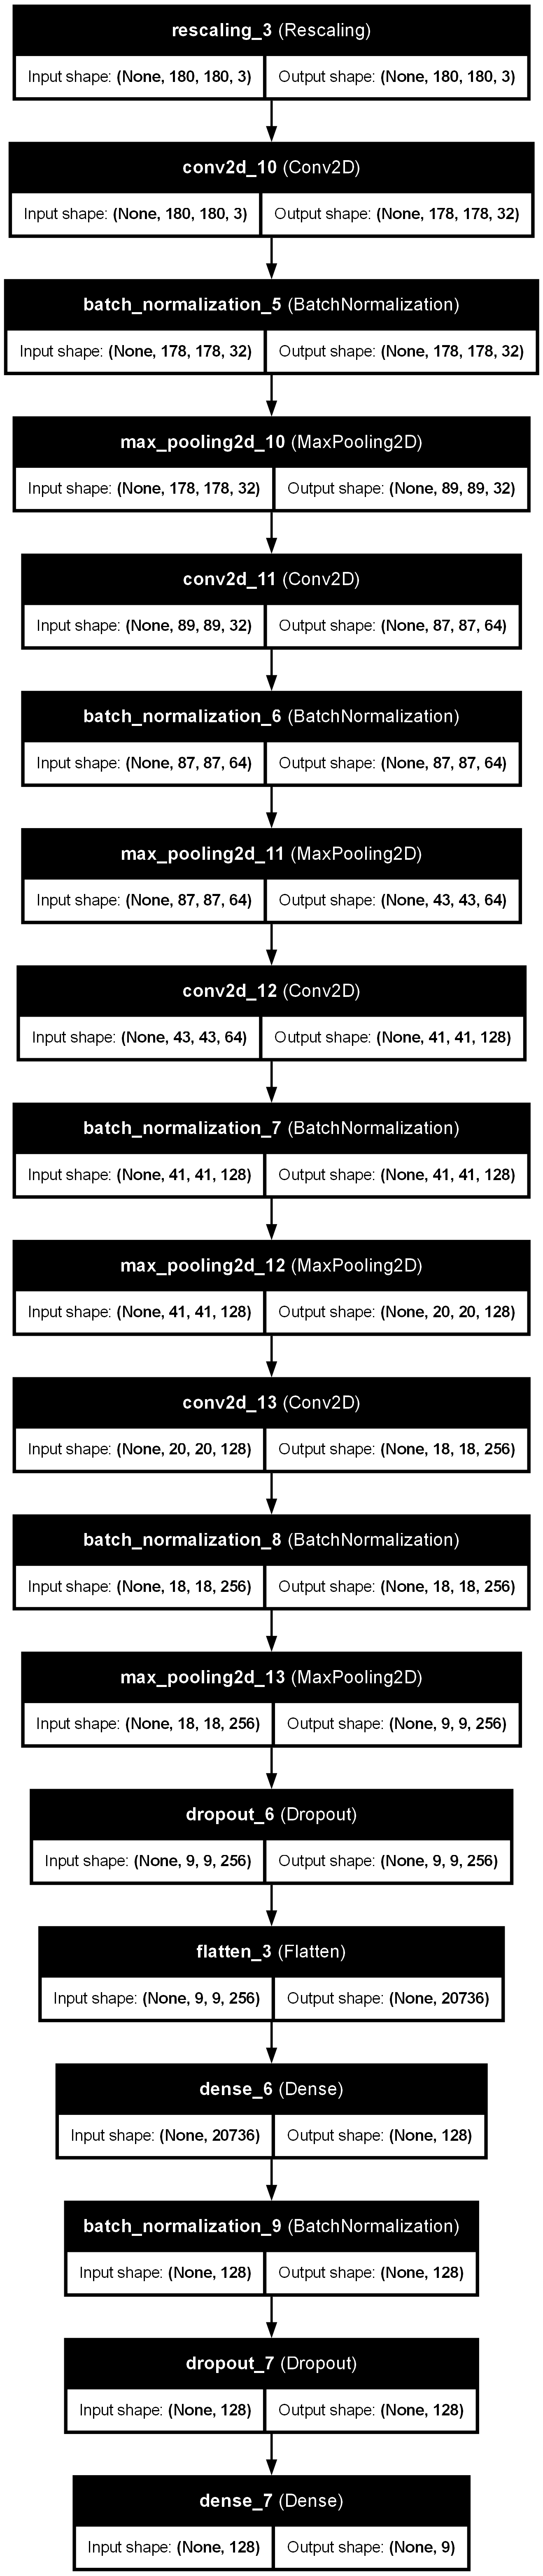

In [26]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [27]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [28]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.3993 - loss: 1.7923
Epoch 1: val_accuracy improved from -inf to 0.13529, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 148s 462ms/step - accuracy: 0.3996 - loss: 1.7911 - val_accuracy: 0.1353 - val_loss: 3.3161
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.6188 - loss: 1.0570
Epoch 2: val_accuracy improved from 0.13529 to 0.55852, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 125s 445ms/step - accuracy: 0.6189 - loss: 1.0568 - val_accuracy: 0.5585 - val_loss: 1.1715
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.7440 - loss: 0.7050
Epoch 3: val_accuracy did not improve from 0.55852
281/281 ━━━━━━━━━━━━━━━━━━━━ 121s 432ms/step - accuracy: 0.7440 - loss: 0.7050 - val_accuracy: 0.3017 - val_loss: 2.2365
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8135 - loss: 0.5265
Epoch 4: val_accuracy improved from 0.55852 to 0.70227, saving model 

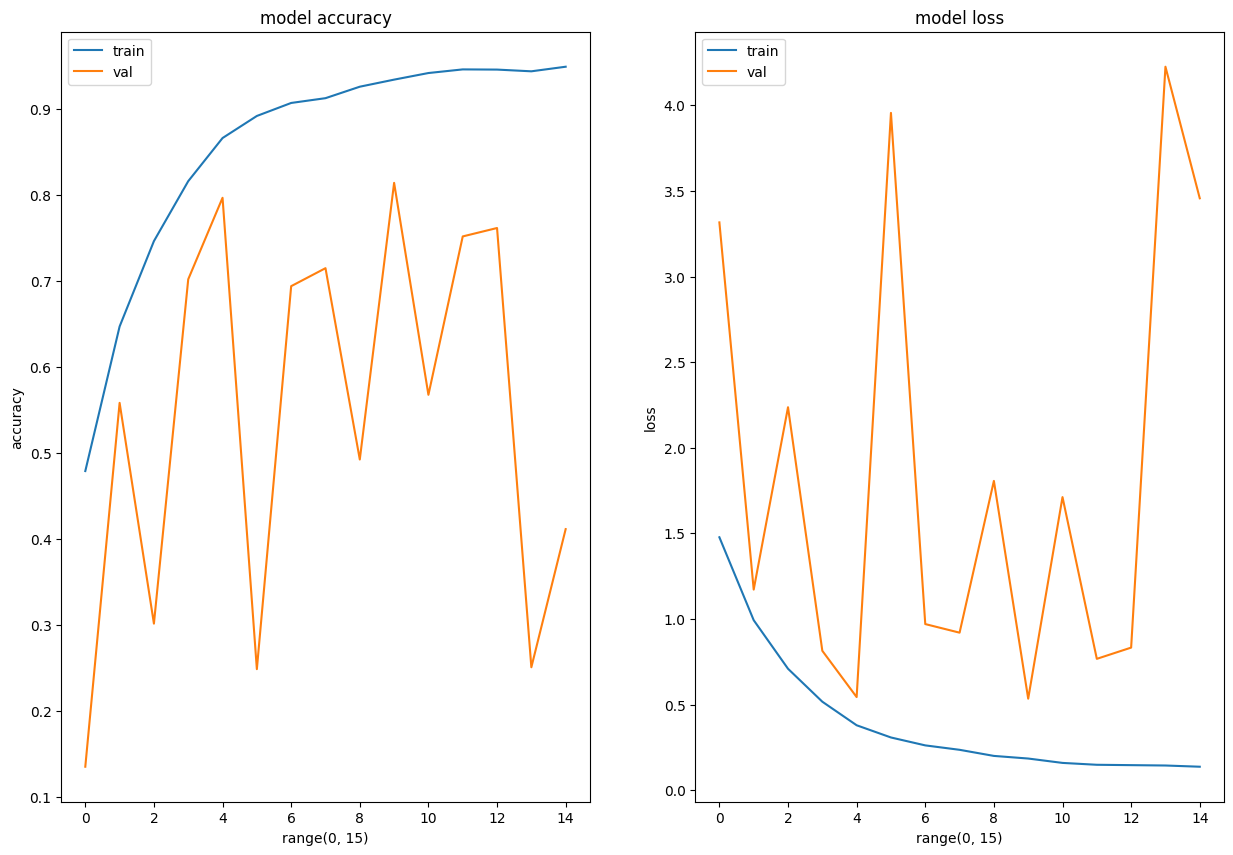

In [29]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


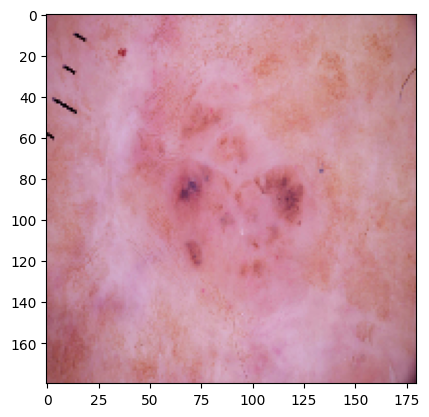

In [35]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )